In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# preparing the data

#import data
df = pd.read_csv("Data/games.csv")
themes_df = pd.read_csv("Data/themes.csv")
mechanics_df = pd.read_csv("Data/mechanics.csv")

# filter ratings so they ar at or above 7/10, so that recommendations are only for highly rated games
df_threshold = df[df['AvgRating'] >= 7][['BGGId', 'AvgRating', 'Name']].copy()

# merge themes and filtered data
themes_df = themes_df.merge(df_threshold[['BGGId', 'AvgRating', 'Name']], on='BGGId', how='left')

# drop missing fields
themes_df = themes_df.dropna(subset=['AvgRating'])

# merge mechanics and filtered data
mechanics_df = mechanics_df.merge(df_threshold[['BGGId', 'AvgRating', 'Name']], on='BGGId', how='left')

# drop missing fields
mechanics_df = mechanics_df.dropna(subset=['AvgRating'])

In [2]:
# K-Means Clustering of Theme

# selecting theme columns
non_theme = ['BGGId', 'AvgRating', 'Name']
theme_columns = [col for col in themes_df.columns if col not in non_theme]

X_theme = themes_df[theme_columns]

# clustering
k_means = KMeans(n_clusters = 10, random_state  = 42)
themes_df['Cluster'] = k_means.fit_predict(X_theme)

In [3]:
# K-Means Clustering of Mechanics

# selecting mechanics columns
non_mechanic = ['BGGId', 'AvgRating', 'Name']
mechanic_columns = [col for col in mechanics_df.columns if col not in non_mechanic]

X_mech = mechanics_df[mechanic_columns]

# clustering
k_means = KMeans(n_clusters = 10, random_state  = 42)
themes_df['Cluster'] = k_means.fit_predict(X_mech)

In [4]:
# K-Means Clustering: combining theme and mechanics

combined_df = themes_df.merge(mechanics_df, on='BGGId', suffixes=('_theme', '_mechanics'))
combined_df['Name'] = combined_df['Name_theme']
combined_df.drop(columns=['Name_theme', 'Name_mechanics'], inplace=True)

# selecting all theme and mechanic columns
not_theme_mech = ['BGGId', 'AvgRating', 'Name', 'Cluster', 'AvgRating_theme', 'AvgRating_mechanics']
theme_mech = [col for col in combined_df.columns if col not in not_theme_mech and pd.api.types.is_numeric_dtype(combined_df[col])]

X_combined = combined_df[theme_mech]

# clustering
k_means = KMeans(n_clusters = 10, random_state  = 42)
combined_df['Cluster'] = k_means.fit_predict(X_combined)

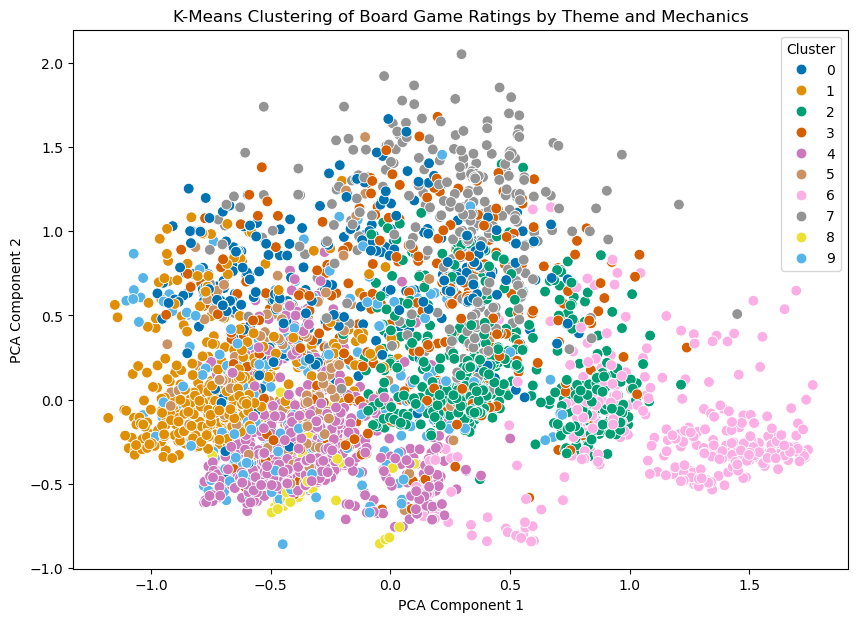

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing the results
X = X_mech
y = combined_df['Cluster']

# reducing dimensionality for visualization purposes
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# adding 2D coordinates to dataframe
combined_df['PCA1'] = X_pca[:, 0]
combined_df['PCA2'] = X_pca[:, 1]

# plotting the clusters with PCA coordinates
plt.figure(figsize=(10, 7))
sns.scatterplot(data=combined_df, x='PCA1', y='PCA2', hue='Cluster', palette='colorblind', s=60)
plt.title('K-Means Clustering of Board Game Ratings by Theme and Mechanics')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.savefig('clusters.png')
plt.show()

In [6]:
# function for recommendation system based on clusters
def recommender (game_name, df=combined_df, theme_mech=theme_mech, top_n=5):

    # check that game is in dataframe
    if game_name not in df['Name'].values:
        return "Sorry, game not found."

    # cluster of target games
    cluster = df.loc[df['Name'] == game_name, 'Cluster'].values[0]

    # subset of games in same cluster
    cluster_subset = df[df['Cluster'] == cluster].copy()

    # cosine similarity of target game and all games in cluster
    game_vec = cluster_subset.loc[cluster_subset['Name'] == game_name, theme_mech].values
    cluster_vec = cluster_subset[theme_mech].values
    similarity = cosine_similarity(game_vec, cluster_vec)[0]

    cluster_subset['Similarity'] = similarity

    # do not include name of input game, sort by highest similarity
    recommendation = cluster_subset[cluster_subset['Name'] != game_name].sort_values(by='Similarity', ascending=False)

    return recommendation[['Name', 'Similarity']].head(top_n)

In [7]:
# Testing the function

recommender("Wingspan")

,Name,Similarity
3403,Fantastic Factories,0.666667
3084,Hostage Negotiator: Crime Wave,0.666667
4945,Ugly Christmas Sweaters,0.596285
3937,Mephisto: The Card Game,0.596285
3109,Everdell,0.577350


In [8]:
# Testing the function

recommender("Ticket to Ride")

,Name,Similarity
717,Ticket to Ride: Europe,0.875000
4747,Ticket to Ride: London,0.790569
5443,Ticket to Ride: Amsterdam,0.790569
1078,Ticket to Ride: Nordic Countries,0.790569
2344,Ticket to Ride: 10th Anniversary,0.750000
